### Imports and Classes

In [1]:
from tqdm import tqdm, trange
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from enum import Enum
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union


class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'


class MlpTransformer(nn.Module):
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)
         self.act = act
         self.fc2 = nn.Linear(h_dim, out_d)
         self.dropout = nn.Dropout(dropout)

     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x
    

class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)


class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

### JSON

In [4]:
import csv

path_csv = '/Users/sonya/Documents/🐬/video_caption/task_11.03.23_2.csv'
with open(path_csv) as file:
    data = list(csv.DictReader(file, delimiter=';'))

In [5]:
with open('./caption.json', 'w') as file:
    json.dump(data, file)

In [6]:
images = [e['image_id'] for e in data]

In [8]:
len(images)

541

### Prepare embeddings

In [9]:
import torch
import skimage.io as io
import clip
from PIL import Image
import pickle
import json
import os
from tqdm import tqdm

json_path = './caption.json'

device = torch.device('cpu')
out_path = './train_embs.pkl'


clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
with open(json_path, 'r') as f:
    data = json.load(f)
print("%0d captions loaded from json " % len(data))
all_embeddings = []
all_captions = []
for i in tqdm(range(len(data))):
    d = data[i]
    img_id = d["image_id"]
    filename = f'/Users/sonya/Documents/🐬/video_caption/dataset/{img_id}'

    image = io.imread(filename)
    image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).cpu()
    d["clip_embedding"] = i
    all_embeddings.append(prefix)
    all_captions.append(d)
    if (i + 1) % 10000 == 0:
        with open(out_path, 'wb') as f:
            pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

with open(out_path, 'wb') as f:
    pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

print('Done')
print("%0d embeddings saved " % len(all_embeddings))


541 captions loaded from json 


100%|█████████████████████████████████████████| 541/541 [00:52<00:00, 10.32it/s]

Done
541 embeddings saved 


### Dataset

In [10]:
class ClipCocoDataset(Dataset):

    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

    def __init__(self, data_path: str,  prefix_length: int, gpt2_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        self.image_ids = [caption["image_id"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]
        if os.path.isfile(f"{data_path[:-4]}_tokens.pkl"):
            with open(f"{data_path[:-4]}_tokens.pkl", 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0
            for caption in captions_raw:
                self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
                self.caption2embedding.append(caption["clip_embedding"])
                max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            # self.max_seq_len = max_seq_len
            with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))

### Utils

In [11]:
def train(dataset, model: ClipCaptionModel, batch_size, epochs, 
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = ""):

    device = torch.device('cpu')
    batch_size = batch_size
    epochs = epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    # save_config(args)
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            progress.update()
            if (idx + 1) % 10000 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
        progress.close()
        if epoch % 1 == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model

In [12]:
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [13]:
import PIL.Image

def predict(path_img):
    image = io.imread(path_img)
    pil_image = PIL.Image.fromarray(image)
    image = preprocess(pil_image).unsqueeze(0).to('cpu')
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix = prefix / prefix.norm(2, -1).item()
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    return generated_text_prefix

In [14]:
def plot_image(path):
    plt.figure(figsize=(6, 6))
    image = mpimg.imread(path)
    plt.axis("off")
    plt.imshow(image)

### Model

In [15]:
prefix_length = 40

In [16]:
dataset = ClipCocoDataset(out_path, prefix_length)

Data size is 541


In [17]:
model_path = './transformer_weights.pt'
model = ClipCaptionPrefix(prefix_length, clip_length=40, prefix_size=640,
                          num_layers=8, mapping_type='transformer')


model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
tokenizer = dataset.tokenizer

In [19]:
tests = ['/Users/sonya/Documents/🐬/video_caption/frames/fishdom/video-4/frame-171.jpg', 
         '/Users/sonya/Documents/🐬/video_caption/frames/fishdom/video-12/frame-616.jpg',
         '/Users/sonya/Documents/🐬/video_caption/frames/gardenscapes/video-9/frame-506.jpg',
         '/Users/sonya/Documents/🐬/video_caption/frames/gardenscapes/video-2/frame-592.jpg',
         '/Users/sonya/Documents/🐬/video_caption/frames/manor-matters/video-2/frame-175.jpg',
         '/Users/sonya/Documents/🐬/video_caption/frames/township/video-3/frame-43.jpg',
         '/Users/sonya/Documents/🐬/video_caption/frames/township/video-9/frame-43.jpg']

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


'A large fish is on a large boat.'

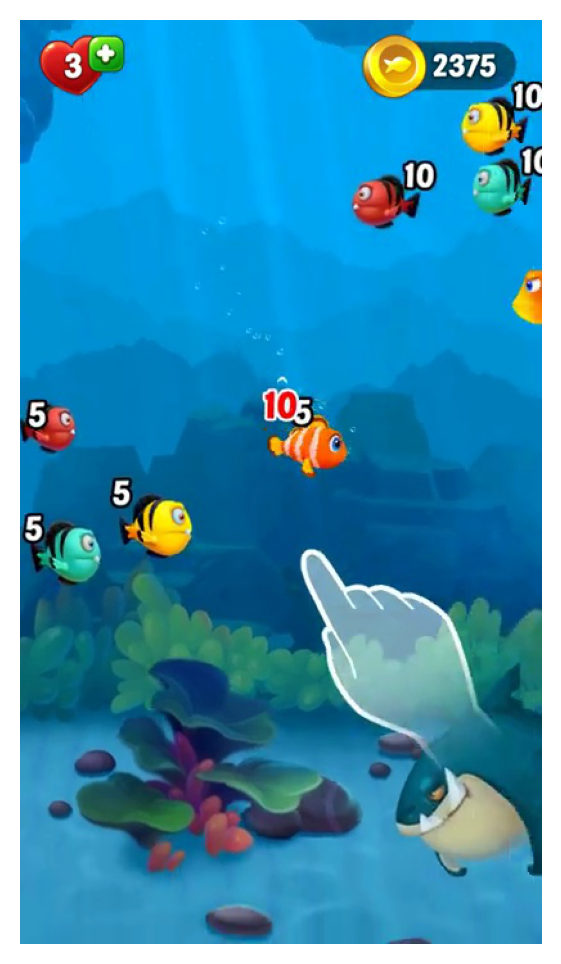

In [20]:
plot_image(tests[0])
predict(tests[0])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


'A fractal drawing of a bear with a sign on it.'

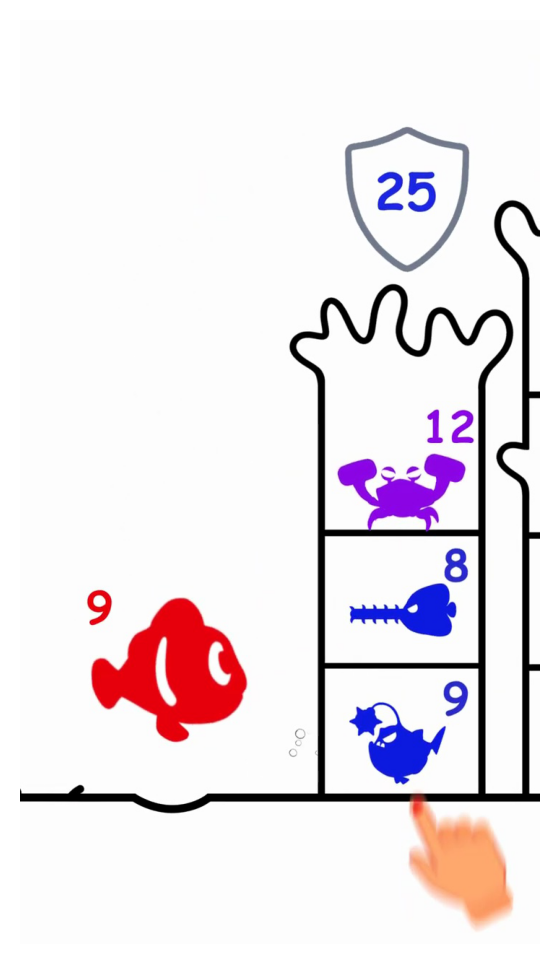

In [21]:
plot_image(tests[1])
predict(tests[1])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


'A child is standing next to a large wooden castle.'

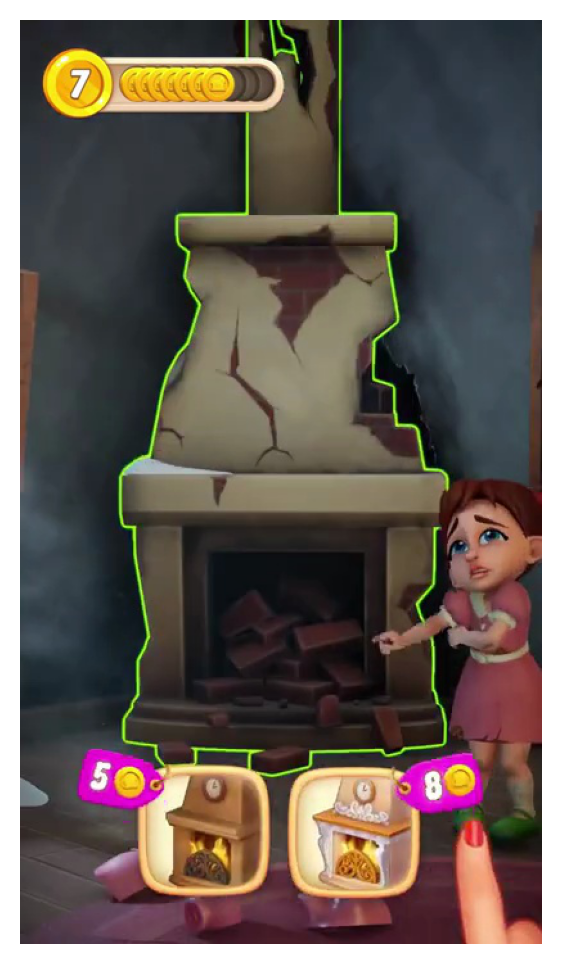

In [22]:
plot_image(tests[2])
predict(tests[2])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


'A girl is walking in the garden of a building.'

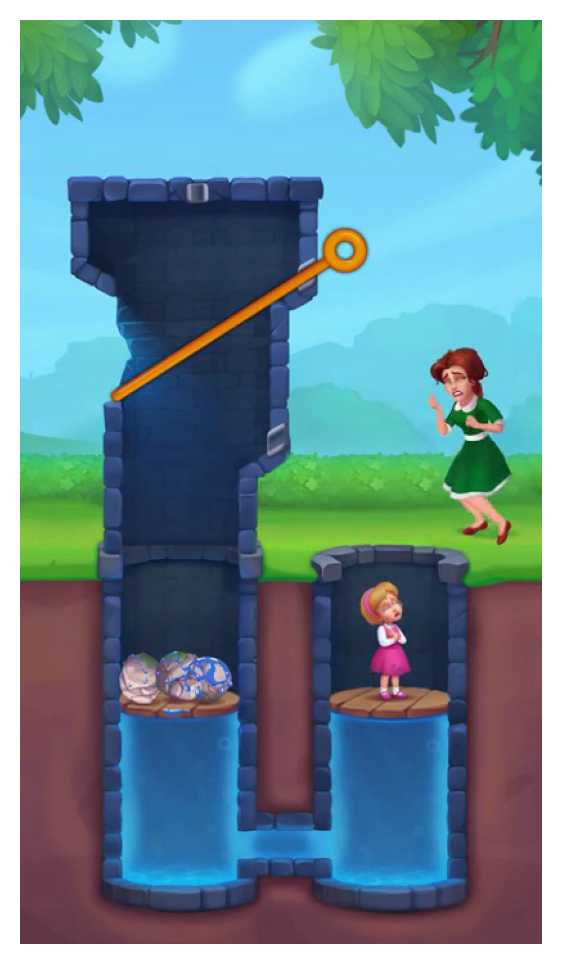

In [23]:
plot_image(tests[3])
predict(tests[3])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


'A woman in a bathtub with a monster in the background.'

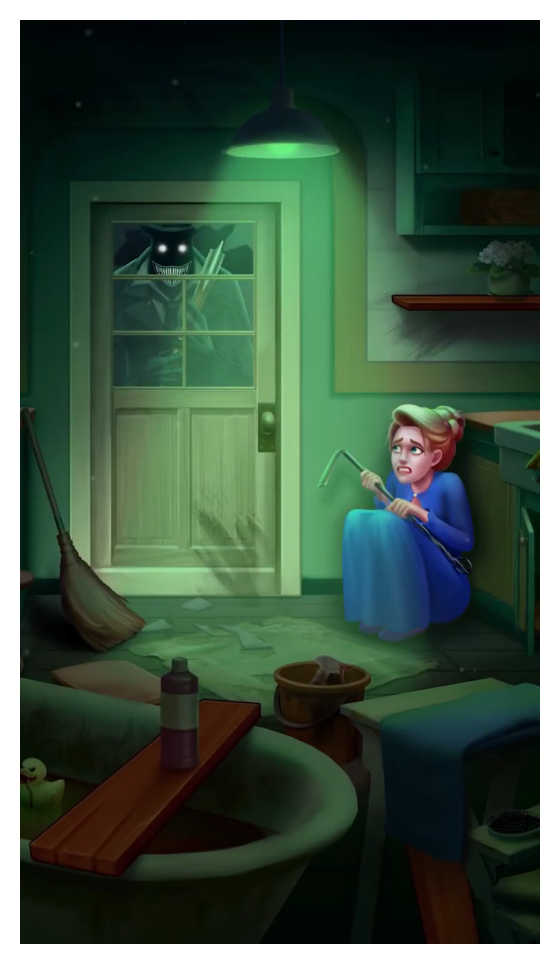

In [24]:
plot_image(tests[4])
predict(tests[4])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


'A person standing next to a computer screen.'

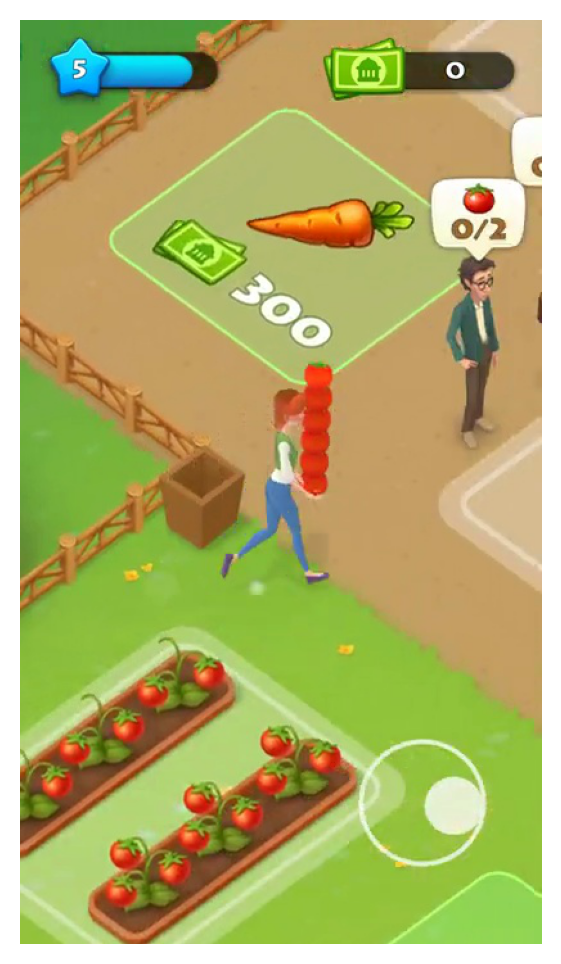

In [25]:
plot_image(tests[5])
predict(tests[5])

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]


'A computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer generated image of a computer'

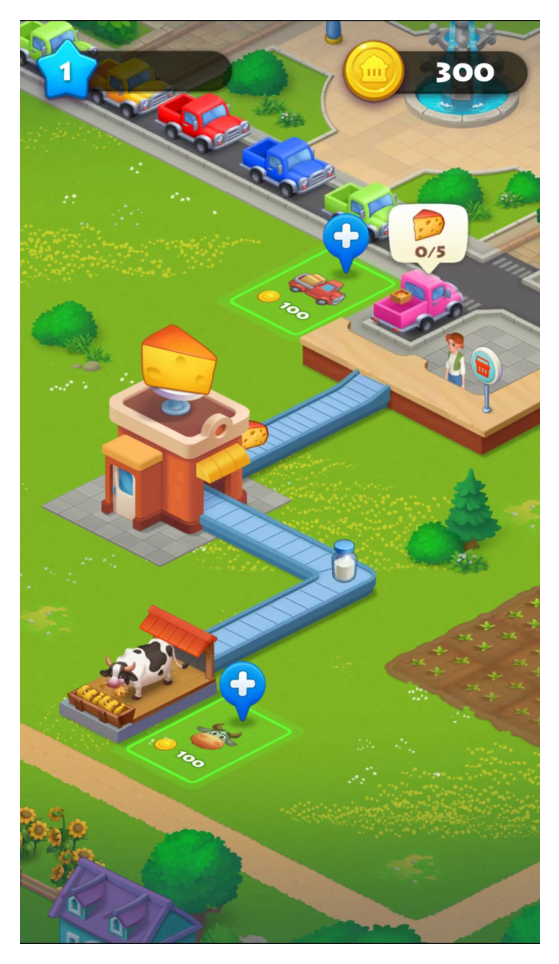

In [26]:
plot_image(tests[6])
predict(tests[6])

### Training

In [28]:
batch_size = 16
epochs = 10

output_dir = '/Users/sonya/Documents/🐬/video_caption'
model = train(dataset, model, batch_size, epochs, output_prefix='prefix', output_dir=output_dir)

/Users/sonya/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


>>> Training epoch 0


prefix: 100%|████████████████████████| 33/33 [01:08<00:00,  2.08s/it, loss=4.26]


>>> Training epoch 1


prefix: 100%|████████████████████████| 33/33 [01:14<00:00,  2.26s/it, loss=3.98]


>>> Training epoch 2


prefix: 100%|████████████████████████| 33/33 [01:06<00:00,  2.00s/it, loss=3.85]


>>> Training epoch 3


prefix: 100%|████████████████████████| 33/33 [01:12<00:00,  2.19s/it, loss=3.72]


>>> Training epoch 4


prefix: 100%|████████████████████████| 33/33 [01:06<00:00,  2.02s/it, loss=3.47]


>>> Training epoch 5


prefix: 100%|█████████████████████████| 33/33 [00:57<00:00,  1.74s/it, loss=3.7]


>>> Training epoch 6


prefix: 100%|█████████████████████████| 33/33 [00:59<00:00,  1.80s/it, loss=3.2]


>>> Training epoch 7


prefix: 100%|████████████████████████| 33/33 [01:08<00:00,  2.06s/it, loss=3.11]


>>> Training epoch 8


prefix: 100%|████████████████████████| 33/33 [01:20<00:00,  2.45s/it, loss=2.88]


>>> Training epoch 9


prefix: 100%|████████████████████████| 33/33 [01:05<00:00,  1.97s/it, loss=2.85]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


'An animated scene depicting a fish and a boat in a sea of fish.'

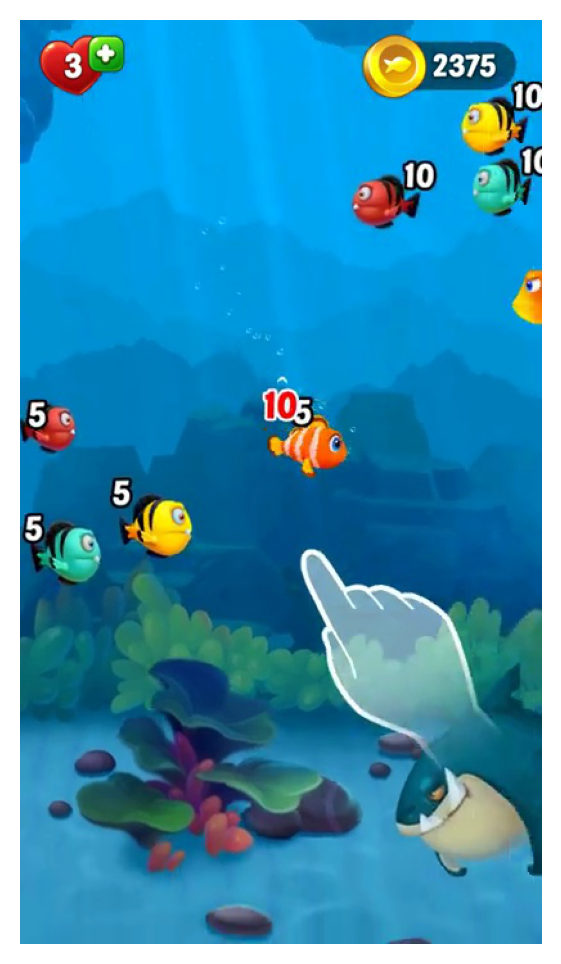

In [29]:
plot_image(tests[0])
predict(tests[0])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


'A video game with a fish and a fish in a circle.'

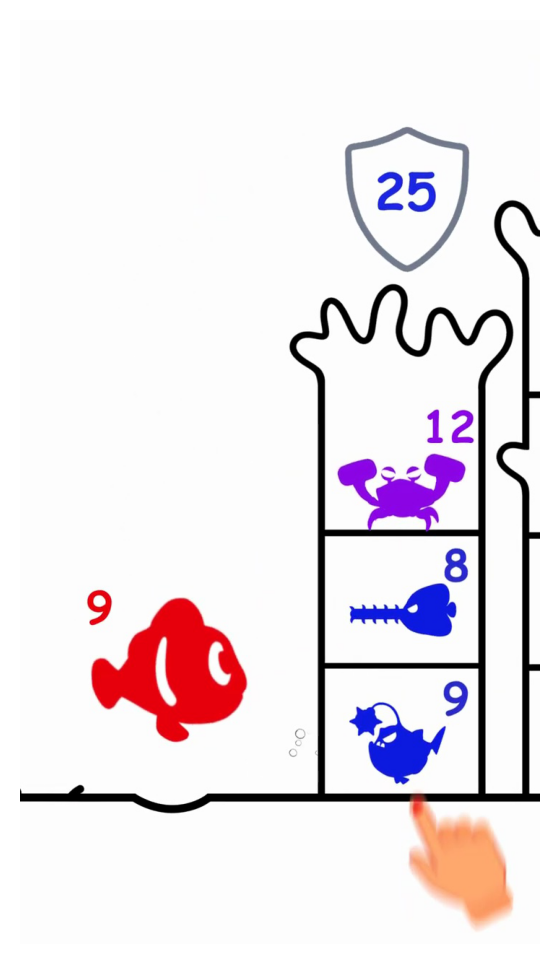

In [30]:
plot_image(tests[1])
predict(tests[1])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


'A video game scene with a woman and a man in a room with a fire and a door.'

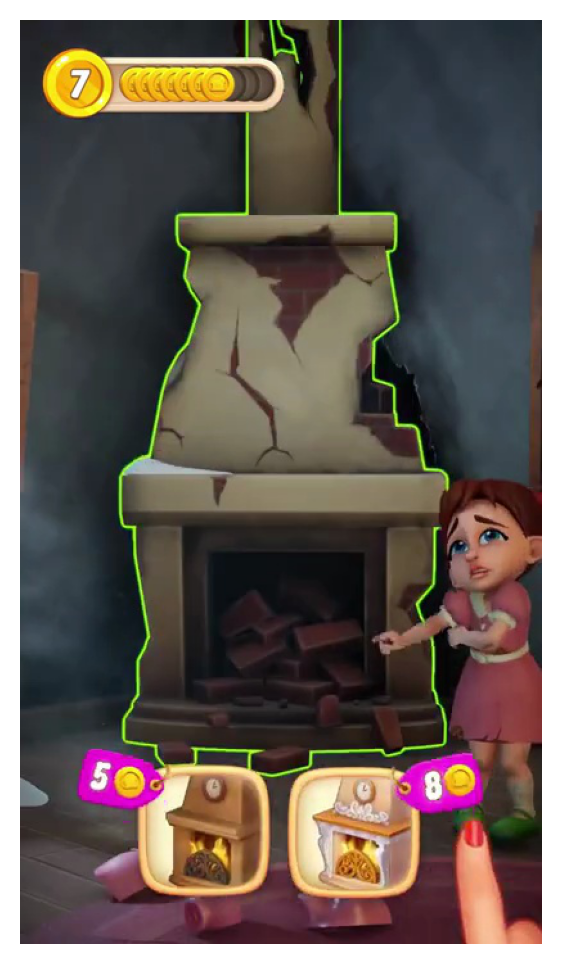

In [31]:
plot_image(tests[2])
predict(tests[2])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


'A video game scene with a woman and a man in a cage.'

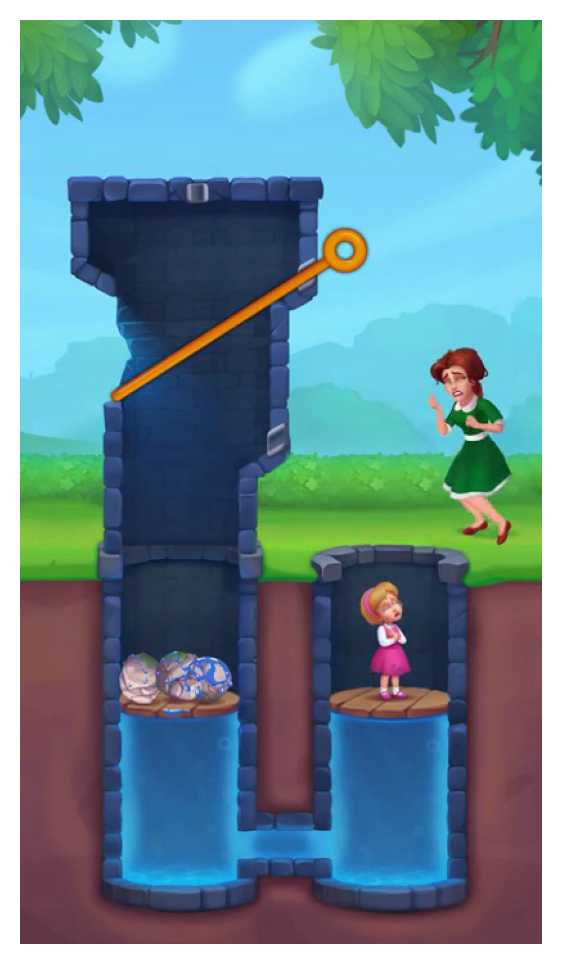

In [32]:
plot_image(tests[3])
predict(tests[3])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


'A video game where a woman is in a room with a woman in a bathtub.'

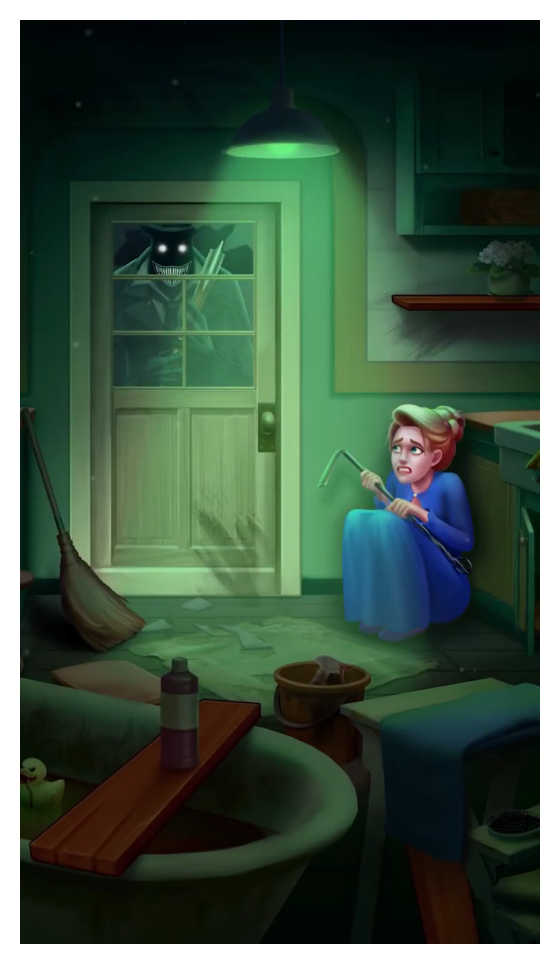

In [33]:
plot_image(tests[4])
predict(tests[4])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


'A video game with a woman and a man in a cage.'

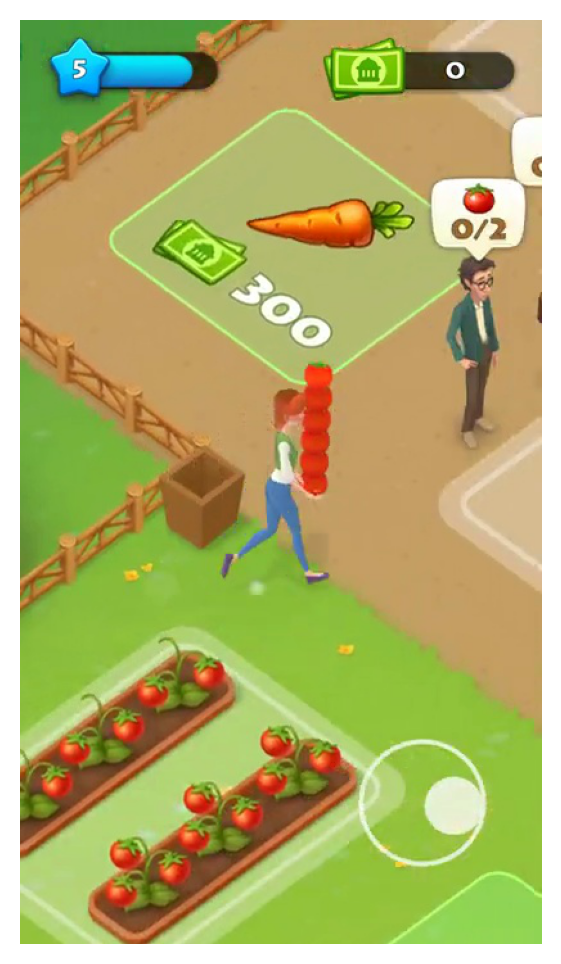

In [34]:
plot_image(tests[5])
predict(tests[5])

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/it]


'A video game with a house and a farm and a house with a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and a farm and'

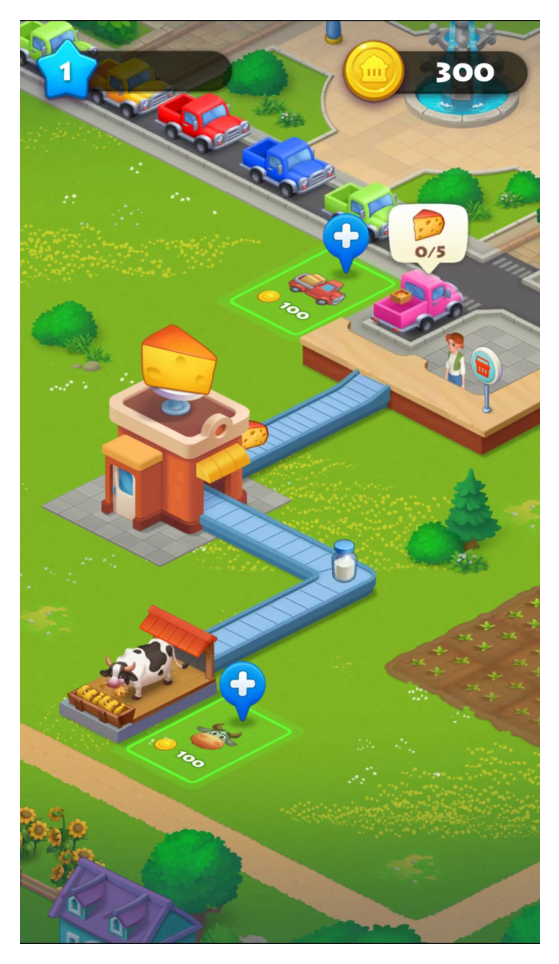

In [36]:
plot_image(tests[6])
predict(tests[6])